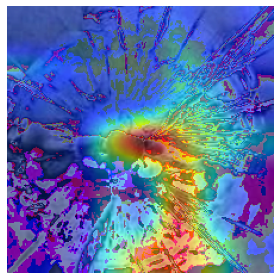

fileName:Snipaste_2024-04-10_16-44-10.png    class: beads   prob: 0.978


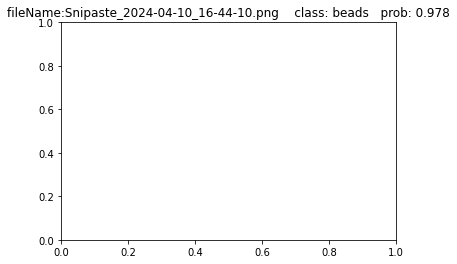

In [4]:
import os
import json
from torchcam.methods import SmoothGradCAMpp
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms.functional import  to_pil_image
from model_v3 import mobilenet_v3_large
from train import n_classes  #此变量是调的train.py种类超参数
from torchcam.utils import overlay_mask

def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

  
    img_path = "微信图片_20240411090738.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    # [N, C, H, W]
    img = data_transform(img)

    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)
    

    # read class_indict
    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    json_file = open(json_path, "r")
    class_indict = json.load(json_file)

    # create model
    model = mobilenet_v3_large(num_classes=n_classes).to(device)
    # load model weights
    model_weight_path = "model/MobileNetV3.pth"
    #1
    model.load_state_dict(torch.load(model_weight_path, map_location=device))
    # 2
    # torch.load(model_weight_path, map_location=device)
    model.eval()
    with SmoothGradCAMpp(model) as cam_extractor:
        out=model(img.to(device))
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
        result = overlay_mask(to_pil_image(img.squeeze(0)), to_pil_image(activation_map[0].squeeze().cpu(), mode='F'), alpha=0.5)
        plt.imshow(result); 
        plt.axis('off');
        plt.tight_layout();
        plt.show()

    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img.to(device))).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    print_res = "fileName:{}    class: {}   prob: {:.3}".format(img_path,class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    plt.title(print_res)
    print(print_res)
    plt.show()


if __name__ == '__main__':
    main()


In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

model = resnet18(pretrained=True).eval()
# Get your input
img = read_image("path/to/your/image.png")
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

with SmoothGradCAMpp(model) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = model(input_tensor.unsqueeze(0))
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

In [ ]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()